# Constructing Scalar Models

Once the modes have been found, we can then make use of them to construct scalar models of our meta-atoms.

In [1]:
# setup 2D plotting 
%matplotlib notebook
from openmodes.ipython import matplotlib_defaults
matplotlib_defaults()
import matplotlib.pyplot as plt

# the numpy library contains useful mathematical functions
import numpy as np

# import useful python libraries
import os.path as osp

# import the openmodes package
import openmodes
from openmodes.constants import eta_0, c
from openmodes.sources import PlaneWaveSource

In [2]:
sim = openmodes.Simulation(name="example3")
mesh = sim.load_mesh(osp.join(openmodes.geometry_dir, "SRR.geo"), parameters={'inner_radius': 2.5e-3}, mesh_tol=0.8e-3)
ring = sim.place_part(mesh);

In [3]:
start_freq = 6e9
start_s = 2j*np.pi*start_freq

num_modes = 4
mode_s, mode_j = sim.singularities(start_s, num_modes);

Having found these modes, we can now use them as a basis for constructing models of our resonator which can describe all the dynamics in a relatively simple form. First we generate the scalar model, using the resonant frequencies and the derivative of the eigenimpedance at the resonance.

In [4]:
scalar_models = sim.construct_models(mode_s, mode_j["J"])

This model is just a simple scalar impedance, represented by 4 polynomial coefficients as $z_n(s') = a/s' + b + cs' - ds'^2$, in terms of normalised frequency parameter $s' = s/Im(s_n)$. We can inspect the values of these coefficients for each mode

In [5]:
for mode in range(num_modes):
    print(scalar_models[mode].coefficients)

[  2.94736315e+02   0.00000000e+00   2.93889786e+00   1.41448123e-02]
[  4.33053974e+02   0.00000000e+00   3.10496307e+00   1.93196432e-01]
[  5.65680256e+02   1.02761877e+01   4.92477774e+00   1.18556405e-01]
[  7.59453362e+02   0.00000000e+00   5.91237107e+00   3.07479249e-01]


In [6]:
num_freqs = 101
freqs = np.linspace(1e9, 30e9, num_freqs)

Together with the the mode distributions, these form a compact but accurate model of our meta-atom. If we invert these impedance values to obtain admittance, the resonance behaviour is easily observed.

<IPython.core.display.Javascript object>


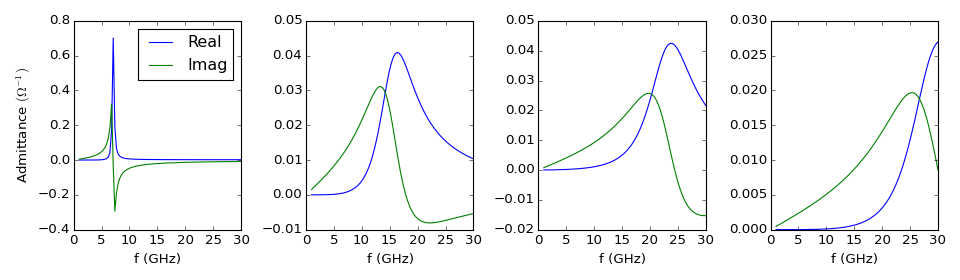

In [7]:
admittance = [1.0/model.scalar_impedance(2j*np.pi*freqs) for model in scalar_models]

plt.figure(figsize=(12,3.5))
plt.subplot(1, 4, 1)
plt.plot(freqs*1e-9, admittance[0].real)
plt.plot(freqs*1e-9, admittance[0].imag)
plt.xlim(0, freqs[-1]*1e-9)
plt.legend(['Real', 'Imag'], loc='upper right')
plt.ylabel('Admittance $(\Omega^{-1})$')
plt.xlabel('f (GHz)')
plt.subplot(1, 4, 2)
plt.plot(freqs*1e-9, admittance[1].real)
plt.plot(freqs*1e-9, admittance[1].imag)
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.subplot(1, 4, 3)
plt.plot(freqs*1e-9, admittance[2].real)
plt.plot(freqs*1e-9, admittance[2].imag)
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.subplot(1, 4, 4)
plt.plot(freqs*1e-9, admittance[3].real)
plt.plot(freqs*1e-9, admittance[3].imag)
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.tight_layout()
plt.show()

Now we utilise this model to calculate the extinction cross section of each mode. First we setup the incident wave polarisation and direction.

In [8]:
e_inc = np.array([1.0, 1.0, 0], dtype=np.complex128)/np.sqrt(2.0)
k_dir = np.array([0, 0, 1], dtype=np.complex128)
plane_wave = PlaneWaveSource(e_inc, k_dir)

p_inc = np.vdot(e_inc, e_inc).real/eta_0
area = np.pi*(0.5*mesh.max_distance)**2

extinction = np.empty(num_freqs, np.complex128)
extinction_modes = np.empty((num_freqs, num_modes), np.complex128)

For comparison purposes we calculate the extinction directly, and time how long this calculation takes. Note that if you increase the mesh density or model a more complex structure, the direct calculation can become very slow, since a large impedance matrix must be filled and solved at every frequency.

In [9]:
%%timeit
for freq_count, freq in enumerate(freqs):
    s = 2j*np.pi*freq
    Z = sim.impedance(s)
    V = sim.source_vector(plane_wave, s)
    extinction[freq_count] = np.vdot(V, Z.solve(V))

1 loops, best of 3: 1.31 s per loop


Now we calculate the extinction based on the scalar model for each mode, and also time this calculation

In [10]:
%%timeit
for freq_count, freq in enumerate(freqs):
    s = 2j*np.pi*freq
    V = sim.source_vector(plane_wave, s)    
    extinction_modes[freq_count] = [np.vdot(V, scalar_models[mode].solve(s, V)) for mode in range(num_modes)]

10 loops, best of 3: 52.7 ms per loop


Timings will vary depending on the exact structure to be solved and the performance of the computer. However in all cases, once the scalar model has been constructed, the system can be solved for different frequencies, input polarisation etc with very low computational cost. This becomes much more important for complex structures with many mesh elements.

We can now see that the extinction cross-section of each mode can be calculated separately

<IPython.core.display.Javascript object>


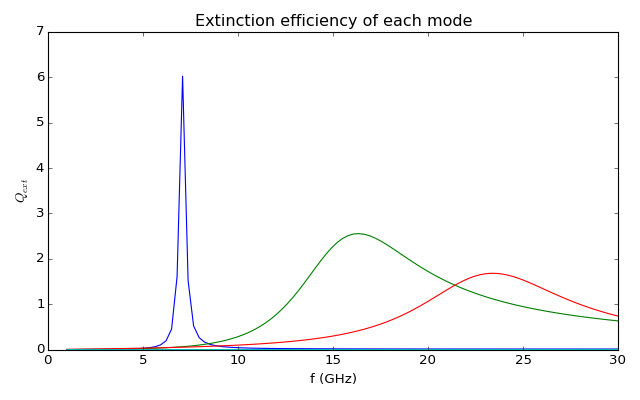

In [11]:
plt.figure()
plt.plot(freqs*1e-9, extinction_modes.real/area/p_inc);
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$Q_{ext}$')
plt.title('Extinction efficiency of each mode')
plt.tight_layout()
plt.show()

Note that the fourth mode does not contribute for the chosen incident wave polarisation. The accuracy of this modal decomposition can be checked by comparison with the direct numerical calculation

<IPython.core.display.Javascript object>


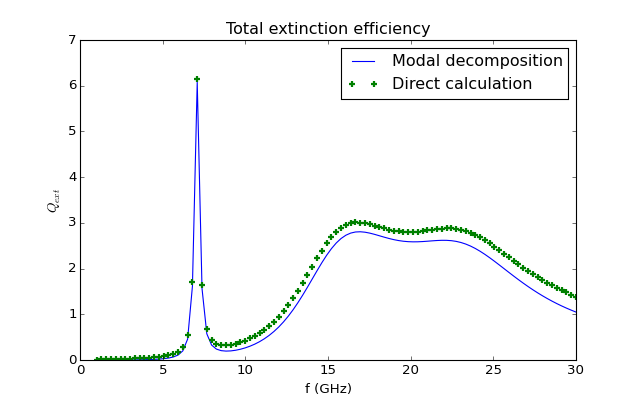

In [12]:
plt.figure()
plt.plot(freqs*1e-9, extinction.real/p_inc/area)
plt.plot(freqs*1e-9, np.sum(extinction_modes.real, axis=1)/p_inc/area, '+')
plt.legend(['Modal decomposition', 'Direct calculation'])
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$Q_{ext}$')
plt.title('Total extinction efficiency')
plt.show()

The small discrepancy in this example is most likely due to the low-order fitting of the impedance of the mode. For some structures, this discrepency may be more significant, so checking with the exact calculation is important for validating the approximation.

In addition, we obtain the reactive stored enerrgy of each mode, given by $W_{m}-W_{e}$, the difference between magnetic and electric and stored energies. At resonance these terms go through zero, following from the imaginary part of the admittance.

<IPython.core.display.Javascript object>


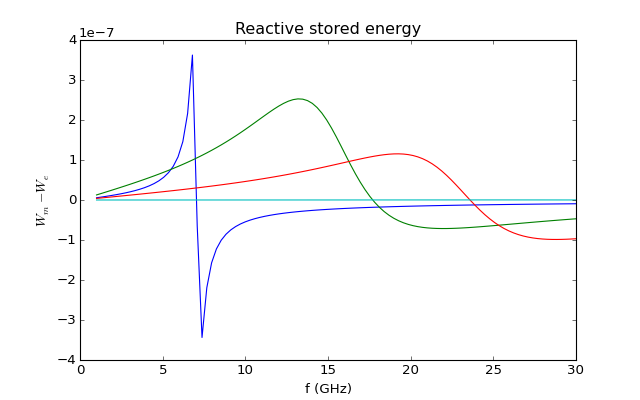

In [13]:
plt.figure()
plt.plot(freqs*1e-9, extinction_modes.imag)
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$W_m-W_e$')
plt.title('Reactive stored energy')
plt.show()